In [190]:
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd
import sys
import argparse
from PIL import Image, ImageDraw, ImageFont
from io import BytesIO
import json
import pprint
import cv2
import os
import time
import tensorflow as tf
from keras import layers, Input, models, optimizers
from keras.models import Model, Sequential
from keras.layers import MaxPooling2D, Conv2D,Activation, Dropout, Flatten, Dense
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

## 카카오 URL, 인증키

In [11]:
API_URL = 'https://kapi.kakao.com/v1/vision/product/detect'
MYAPP_KEY = '89b7d96fc38f45fbf6ca52c2b13d2ad8'
url = "https://kapi.kakao.com/v1/vision/product/detect"       
headers = {'Authorization': 'KakaoAK {}'.format(MYAPP_KEY)}

## 1. 카카오 API 사용해서 이미지 label 달아보기

### 카카오 API로 사진에 이미지 label 어떻게 달리는지 확인, 그 외 작업 X

In [230]:
# 1. 사용할 이미지 설정


img_dir ='C:/python_DA/img/0.jpg'                   # 학원컴퓨터
#img_dir ='C:/Jupyter_Script/img/test/test (100).jpg'      # 노트북

In [231]:
# 2. 카카오 API 활용해서 사진 정보 받아오기 (1) : 사진크기


API_URL = 'https://kapi.kakao.com/v1/vision/product/detect'
MYAPP_KEY = '89b7d96fc38f45fbf6ca52c2b13d2ad8'
url = "https://kapi.kakao.com/v1/vision/product/detect"       
headers = {'Authorization': 'KakaoAK {}'.format(MYAPP_KEY)}

filename = img_dir                                              # 이미지 주소
files = { 'file' : open(filename, 'rb')}
response = requests.post(url, headers=headers, files=files)
result = response.json()
fig_w, fig_h = result['result']['width'], result['result']['height']
print(fig_w, fig_h)

495 512


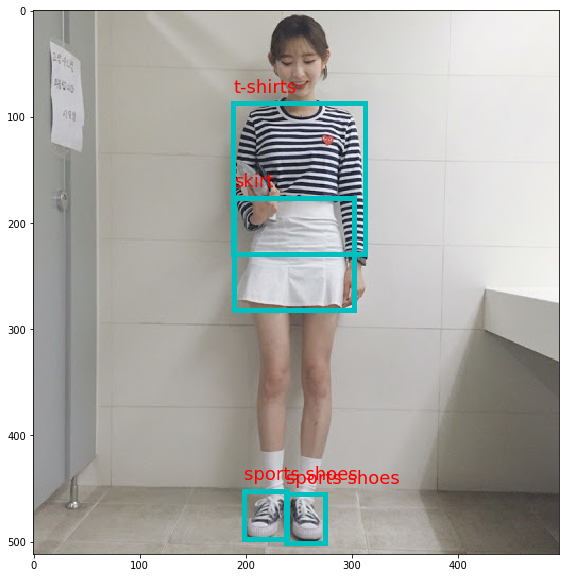

In [232]:
# 2. 카카오 API 활용해서 사진 정보 받아오기 (2) : 사물에 대한 정보


img = mpimg.imread(img_dir)                                       # 이미지 주소
fig,ax = plt.subplots(figsize=(10,10))

for each in result['result']['objects']:

    x, y = each['x1']*fig_w, each['y1']*fig_h
    w, h = each['x2']*fig_w - x, each['y2']*fig_h - y

    rect = patches.Rectangle((x, y), w, h, lw=5, edgecolor='c', facecolor='none')
    ax.add_patch(rect)
    plt.text(x,y-10, each['class'], size=18, color='red')
    
ax.imshow(img)
plt.show()

## 2. 카카오 API 사용해서 이미지 정보 확인 및 이미지 자르기

### 카카오 API 사용해서 이미지 정보(상하의) 확인하고, 이미지 잘라서 plt.show()

In [134]:
# 1. 사용할 이미지 설정


img_dir ='C:/python_DA/img/test/018.jpg'                         # 학원컴퓨터
#img_dir ='C:/Jupyter_Script/img/test/test (103).jpg'            # 노트북

In [146]:
# 2. 카카오 API 사용해서 사진에 대한 정보 가져오기


API_URL = 'https://kapi.kakao.com/v1/vision/product/detect'
MYAPP_KEY = '89b7d96fc38f45fbf6ca52c2b13d2ad8'
url = "https://kapi.kakao.com/v1/vision/product/detect"       
headers = {'Authorization': 'KakaoAK {}'.format(MYAPP_KEY)}

files = { 'file' : open(img_dir, 'rb')}
response = requests.post(url, headers=headers, files=files)
result = response.json()
fig_w, fig_h = result['result']['width'], result['result']['height']

t-shirts
pants
shoes
tote bag
tote bag
glasses


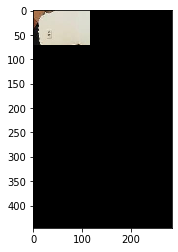

In [152]:
# 3. 이미지 자르기 : 실패

    
img = Image.open(img_dir)
#img = mpimg.imread(img_dir)       

info = []
for each in result['result']['objects']:
    info.append(each)
#print(info)
    
for _ in range(len(info)):
    print(info[_]['class'])
    
    if info[_]['class'] in ('pants', 'skirts', 't-shirts', 'shirts'):             
        
        # 'class'라는 key 값으로 뽑아내서 'calss' key에 해당되는 모든 value가 포함됨
        # pants, skirts 등 특정 옷만 뽑아내려는 조건문이 적용이 안됨
        # 이미지도 필요한 부분만 잘리는 것이 아니라 모두 잘려버림
        # 이를 해결한 코드 -> 밑에 코드

        x = info[_]['x1']*fig_w - 50
        y = info[_]['y1']*fig_h - 50
        w = info[_]['x2']*fig_w + 50
        h = info[_]['y2']*fig_h + 50
        
        img = img.crop((x,y,w,h))
        plt.imshow(img)


t-shirts
pants
shoes
tote bag
tote bag
glasses


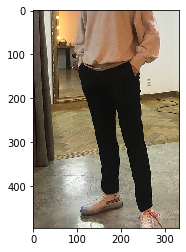

In [169]:
# 3. 이미지 자르기 : 성공


# 1) 사진 정보 담기
info = []
for each in result['result']['objects']:                 
    each = list(each.values())                       
    info.append(each)
#print(info)
    
# 순서 : x1, y1, x2, y2, class
# 'class' key로 호출할 때, 여러 value(glasses, shoes 등) 포함됬었음
# 조건으로 pants, t-shirts 등 만 걸러내기 어려워서 이를 보안
    
    

# 2) 사진 잘라내기     
# 계속 새로운 이미지를 띄워줘야 앞에서 잘린 이미지로 계속 작업하지 않음
for _ in range(len(info)):
    img = Image.open(img_dir)
    category = info[_][4]
    print(category)
    
    if category in ('shirts','t-shirts','pants','skirts'):

        x = info[_][0]*fig_w - 100
        y = info[_][1]*fig_h - 100
        w = info[_][2]*fig_w + 50
        h = info[_][3]*fig_h + 50
        img = img.crop((x,y,w,h))
        plt.imshow(img)                                    # 하나 사진만 나오지만 
        img.show()                                         # 팝업창으로 띄워보면 잘 실행됨 확인

## 3. 이미지 분리 및 따로 저장하기

### 위에서 작성한 이미지 분리 코드를 기반으로 상의, 하의 분리된 이미지를 저장

In [ ]:
# 1. 폴더 생성 함수


def createfolder(foler_dir):
    try:
        if not os.path.exists(folder_dir):
            os.makedirs(folder_dir)
    except OSError:
        print('Error Creating directory'+folder_dir) 


In [ ]:
# 2. 자른 이미지 저장할 폴더 생성


# 1). cropped_img 폴더 생성
folder_dir = 'C:/python_DA/img/cropped_img'
createfolder(folder_dir)

# 2). cropped_img/top 하위폴더 생성
folder_dir ='C:/python_DA/img/cropped_img/top'                  # 상의 저장할 폴더
createfolder(folder_dir)

# 3). cropped_img/bottom 하위폴더 생성
folder_dir = 'C:/python_DA/img/cropped_img/bottom'              # 하의 저장할 폴더
createfolder(folder_dir)

In [239]:
# 3. 작업할 이미지 설정

img_dir ='C:/python_DA/img/test/018.jpg'                         # 학원컴퓨터
#img_dir ='C:/Jupyter_Script/img/test/test (103).jpg'            # 노트북 

[[0.444744, 0.511719, 0.768194, 0.896484, 'pants'], [0.512129, 0.216797, 0.730458, 0.582031, 'shirts'], [0.45283, 0.878906, 0.633423, 0.962891, 'sports shoes'], [0.601078, 0.886719, 0.762803, 0.955078, 'sports shoes']]
pants
shirts
sports shoes
sports shoes


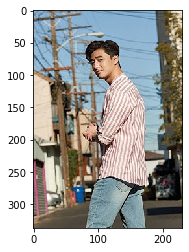

In [240]:
# 4. 이미지 자르고 저장하기 


# 1) 카카오 API 받아오기
API_URL = 'https://kapi.kakao.com/v1/vision/product/detect'
MYAPP_KEY = '89b7d96fc38f45fbf6ca52c2b13d2ad8'                   # 개인 접근 key
url = "https://kapi.kakao.com/v1/vision/product/detect"       
headers = {'Authorization': 'KakaoAK {}'.format(MYAPP_KEY)}

files = { 'file' : open(img_dir, 'rb')}
response = requests.post(url, headers=headers, files=files)
result = response.json()
fig_w, fig_h = result['result']['width'], result['result']['height']
    

# 2) 카카오 API 정보 저장
info = []
for each in result['result']['objects']:
    each = list(each.values())                                  # 순서 : x1, y1, x2, y2, class
    info.append(each)
print(info)


# 2) 상하의 구분해서 자르고 이미지 저장
for _ in range(len(info)):
    img = Image.open(img_dir)
    category = info[_][4]
    print(category)
    
    if category in ('shirts','t-shirts'):

        x = info[_][0]*fig_w - 100
        y = info[_][1]*fig_h - 100
        w = info[_][2]*fig_w + 50
        h = info[_][3]*fig_h + 50
        path = 'C:/python_DA/img/cropped_img/top/'   
        name = path + category + str(time.time()) + '.jpg'     # 저장 이름을 시간으로 해둠
        img = img.crop((x,y,w,h))                              # 겹치지 않는 번호로 저장하기 위해 
        img.save(name)
        plt.imshow(img)
        img.show() 

    elif category in ('pants','skirts'): 
        
        x = info[_][0]*fig_w - 100
        y = info[_][1]*fig_h - 100
        w = info[_][2]*fig_w + 50
        h = info[_][3]*fig_h + 50
        path = 'C:/python_DA/img/cropped_img/bottom/'
        name = path + category + str(time.time()) + '.jpg'
        img = img.crop((x,y,w,h))
        img.save(name)
        plt.imshow(img)
        img.show() 

## 4. 이미지 분리 및 속성 알려주는 함수 생성

### 위 코드로 이미지 구분(crop)하고 저장하지 않고 옷 종류 각각 속성을 알려주는 함수 생성

In [200]:
# 1. 사용할 이미지 설정

#img_dir ='C:/python_DA/img/test/018.jpg'                         # 학원컴퓨터
#img_dir ='C:/Jupyter_Script/img/test/test (103).jpg'            # 노트북

In [242]:
# 2. 이미지 분리 및 속성 알려주는 함수 생성


def seperate_n_predict(img_dir, model_dir, var):
    
    # 1) 사용할 model 설정
    model = load_model(model_dir) 
    model_json = model.to_json()
    
    # 2) 카카오 API 설정
    API_URL = 'https://kapi.kakao.com/v1/vision/product/detect'
    MYAPP_KEY = '89b7d96fc38f45fbf6ca52c2b13d2ad8'
    url = "https://kapi.kakao.com/v1/vision/product/detect"       
    headers = {'Authorization': 'KakaoAK {}'.format(MYAPP_KEY)}
    files = { 'file' : open(img_dir, 'rb')}
    response = requests.post(url, headers=headers, files=files)
    result = response.json()
    fig_w, fig_h = result['result']['width'], result['result']['height']
    
    # 3) 카카오 API 정보 저장
    info = []
    for each in result['result']['objects']:
        each = list(each.values())                                  # 순서 : x1, y1, x2, y2, class
        info.append(each)

    # 4) 사진 자르기 
    for _ in range(len(info)):
        img = Image.open(img_dir)
        category = info[_][4]

        if category in ('shirts','t-shirts'):

            x = info[_][0]*fig_w - 5
            y = info[_][1]*fig_h - 5
            w = info[_][2]*fig_w + 5
            h = info[_][3]*fig_h + 5
#             path = 'C:/python_DA/img/cropped_img/top/'   
#             name = path + category + str(time.time()) + '.jpg'     
            img = img.crop((x,y,w,h))                               
            plt.imshow(img)
            img.show() 
        
            img = img.resize((150,150))
            data = np.array(img)
            data = data.astype('float')
            data = data/255
            data = data.reshape((1,150,150,3))

            var = ['camo', 'check', 'dot', 'floral', 'graphic', #'lace', 
                   'leopard', 'none', 'stripe']
            result = var[model.predict_classes(data)[0]]
            print(f'옷 : {category}')
            print(f'패턴 : {result}')        
        
        elif category in ('pants','skirts'): 

            x = info[_][0]*fig_w - 5
            y = info[_][1]*fig_h - 5
            w = info[_][2]*fig_w + 5
            h = info[_][3]*fig_h + 5
#             path = 'C:/python_DA/img/cropped_img/top/'   
#             name = path + category + str(time.time()) + '.jpg'     
            img = img.crop((x,y,w,h))                               
            plt.imshow(img)
            img.show() 

        
        # 5) 자른 사진 model 예측 
            img = img.resize((150,150))
            data = np.array(img)
            data = data.astype('float')
            data = data/255
            data = data.reshape((1,150,150,3))

            #var = ['camo', 'check', 'dot', 'floral', 'graphic','leopard', 'none', 'stripe']
            #var = ['check', 'dot', 'floral', 'graphic', 'leopard', 'none', 'stripe', 'tribal']
            result = var[model.predict_classes(data)[0]]
            print(f'옷 : {category}')
            print(f'패턴 : {result}')


옷 : pants
패턴 : dot
옷 : shirts
패턴 : check


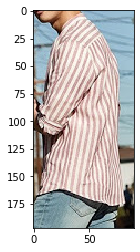

In [243]:
# 3. 확인하기

var = ['check', 'dot', 'floral', 'graphic', 'leopard', 'none', 'stripe', 'tribal']
img_dir = 'C:/python_DA/img/test/018.jpg'    
model_dir = 'C:/python_DA/프로젝트/model/pattern_no_camo_정확도76.h5'    

seperate_n_predict(img_dir, model_dir, var)

## 모델로 예측해서 비교해보기

--이 사진의 pattern 값--
정확도 56 : lace
정확도 69 : none
정확도 ?? : dot
정확도 ?? : check


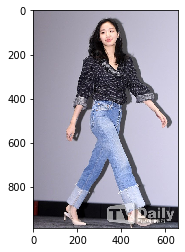

In [115]:
from keras.models import load_model
import json
import pprint


# 1. 사용할 모델
model_1 = load_model('C:/python_DA/프로젝트/model/model_pattern_정확도56.h5')            # 학원컴퓨터
model_2 = load_model('C:/python_DA/프로젝트/model/model_pattern_정확도69.h5') 
model_3 = load_model('C:/python_DA/프로젝트/model/model_pattern_final.h5') 


#model = load_model('C:/Jupyter_script/파이널프로젝트/model/model_pattern_final.h5')   # 노트북
#model_json = model.to_json()

model_json_1 = model_1.to_json()
model_json_2 = model_2.to_json()
model_json_3 = model_3.to_json()

# 예측할 이미지
img = Image.open('C:/python_DA/img/test/020.jpg')                                   # 학원컴퓨터 
#img = Image.open('C:/Jupyter_script/img/test/test (103).jpg')                      # 노트북
plt.imshow(img)

img = img.resize((150,150))
data = np.array(img)
data = data.astype('float')
data = data/255
data = data.reshape((1,150,150,1))   # grayscale 학습 모델에 넣으려면 shape의 depth:1, RGB 모델은 3


#result = np.argmax(data)
var = ['camo', 'check', 'dot', 'floral', 'graphic', #'lace', 
       'leopard', 'none', 'stripe']
#var = list(training_set.class_indices.keys())                     # y에 해당되는 값
#print(var)

result_1 = model_1.predict_classes(data)[0]
result_2 = model_2.predict_classes(data)[0]
result_3 = model_3.predict_classes(data)[0]


#print(result)

print('--이 사진의 pattern 값--')
print(f'정확도 56 : {var[result_1]}')
print(f'정확도 69 : {var[result_2]}')
print(f'정확도 ?? : {var[result_3]}')